# EfficientNet-B0

To see the performance of the model if we used natural sampling of the test dataset.

## Setup

In [1]:
from IPython.display import display_html


def restart_kernel():
    display_html("<script>Jupyter.notebook.kernel.restart()</script>", raw=True)


restart_kernel()

### Packages and Libraries

In [2]:
# Basic imports
import os
import time
import sys
from IPython.display import clear_output
import random
import numpy as np

import pandas as pd
import math


# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# Image processing and viewing
from PIL import Image
import cv2
from skimage import exposure
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch

2024-04-21 18:09:14.501467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 18:09:14.655905: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 18:09:15.495025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-21 18:09:15.495166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### Configurations

### Static Configs
Don't have to be changed for each run

In [3]:
# Set seeds to ensure reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # For multi-GPU setups

In [4]:
# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth before initializing GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(
            "Num GPUs Available: Physical GPUs=",
            len(gpus),
            " | Logical GPUs=",
            len(logical_gpus),
        )
    except RuntimeError as e:
        # Handle potential errors here
        print(e)

Num GPUs Available: Physical GPUs= 1  | Logical GPUs= 1


2024-04-21 18:09:19.027600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 18:09:19.315305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14485 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


### Dynamic Configs
Change these for each run based on the experiment

In [5]:
# Set paths
base_data_path = "../../aws_s3/Ddr/"  # <-- Add path to the numpy files here
output_path = "output/"  # <-- Add path to the output folder here

In [6]:
# Cross Testing

# Decide if we are evaluating only 1 dataset or cross testing with other dataset as well
cross_testing = False

cross_data_path = "../../aws_s3/Idrid_224_Raw/"  # <-- Add path to the numpy files here

In [7]:
# Pre-processing steps
# Choose if you want to perform each of the following pre-processing steps
preprocess_IENR = True
preprocess_Crop = True
preprocess_CN = True

In [8]:
# Augmentation config

# decide whether to apply augmentation or not
apply_augmentation = False

# decide whether to apply brightness augmentation or not
aug_br_flag = 1  # 1 = Augment Brightness, anything else = No Brightness Augmentation

In [9]:
# decide if we want to do validation or only Train-Test
validation_flag = False

In [10]:
# Decide if we want to remake the train-test split for the train data and use whole of the cross data
reshufle_flag = False

## Functions

In [11]:
# To display a progress bar
def update_progress(progress):
    # progress is a float between 0 and 1

    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait=True)
    text = "Progress: [{0}] {1:.1f}%".format(
        "#" * block + "-" * (bar_length - block), progress * 100
    )
    print(text)

In [12]:
def resize_image(img, desired_size=(224, 224)):
    # resizing the image
    new_img = img.resize(desired_size)
    return new_img

In [13]:
# luminosity and noise removal function
def luminosity_image(image_path, desired_size=(224, 224)):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)

    # Merge back LAB channels
    lab_eq = cv2.merge((l_eq, a, b))
    enhanced_image = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # Image noise removal using Gaussian filter
    filtered_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Convert to PIL image
    filtered_image = Image.fromarray(filtered_image)

    # Resize the image
    filtered_image = filtered_image.resize(desired_size)

    # # Save the preprocessed image
    # image_name = os.path.basename(image_path)
    # output_path = os.path.join(output_dir, image_name)
    # cv2.imwrite(output_path, filtered_image)

    # converting to numpy array
    filtered_image = np.array(filtered_image)

    return filtered_image

In [14]:
# modified original function to directly take in a numpy array
def crop_image(img_np, threshold=15, resize_flag=False, desired_size=(224, 224)):
    # img_np = np.array(img)
    assert img_np.shape == (224, 224, 3)
    x_dim = img_np.shape[0]
    y_dim = img_np.shape[1]
    pixel_sums = img_np.sum(axis=2)
    x_arr = pixel_sums.sum(axis=1)
    y_arr = pixel_sums.sum(axis=0)
    x_start = np.where(x_arr > threshold * y_dim)[0][0]
    x_end = np.where(x_arr > threshold * y_dim)[0][-1]
    y_start = np.where(y_arr > threshold * x_dim)[0][0]
    y_end = np.where(y_arr > threshold * x_dim)[0][-1]
    new_img = img_np[x_start:x_end, y_start:y_end]
    new_img = Image.fromarray(new_img)
    if resize_flag:
        new_img = new_img.resize(desired_size)
    # convert to numpy
    new_img = np.array(new_img)
    return new_img

In [15]:
# modified original function to directly take in a numpy array
def normalize_image(img_np):
    # Convert image to numpy array
    # img_np = np.array(img)
    assert img_np.shape == (224, 224, 3)
    # Calculate mean and standard deviation (std) channel-wise
    mean_channels = np.mean(img_np, axis=(0, 1))
    std_channels = np.std(img_np, axis=(0, 1))

    # Normalize each channel separately
    normalized_image = np.zeros_like(img_np, dtype=np.float32)
    for channel in range(img_np.shape[2]):
        normalized_image[:, :, channel] = (
            img_np[:, :, channel] - mean_channels[channel]
        ) / std_channels[channel]

    # Scale values to be within [0, 255]
    normalized_image = (
        (normalized_image - np.min(normalized_image))
        / (np.max(normalized_image) - np.min(normalized_image))
        * 255
    )

    # Clip and return the normalized image
    normalized_image = np.clip(normalized_image, 0, 255)
    return normalized_image.astype(np.uint8)

In [16]:
## Augemntation Helper Fucntions
## image is an np array of the image
def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image


def flip_image(image):
    flip_variations = [
        (False, False),  # No flip
        (True, False),  # Horizontal flip
        (False, True),  # Vertical flip
        (True, True),  # Both flips
    ]

    random.shuffle(flip_variations)
    augmented_images = []

    for flip_horizontal, flip_vertical in flip_variations[:4]:
        if flip_horizontal and flip_vertical:
            augmented_images.append(cv2.flip(image, -1))  # horizontal and vertical
        elif flip_horizontal:
            augmented_images.append(cv2.flip(image, 1))  # horizontal
        elif flip_vertical:
            augmented_images.append(cv2.flip(image, 0))  # vertical
        else:
            augmented_images.append(image)  # No flip

    return augmented_images


def shear_image(image, shear_range):
    height, width = image.shape[:2]
    shear_value = random.uniform(-shear_range, shear_range)

    if shear_value < 0:
        shear_matrix = np.array([[1, -shear_value, 0], [0, 1, 0]])
    else:
        shear_matrix = np.array([[1, shear_value, 0], [0, 1, 0]])

    sheared_image = cv2.warpAffine(image, shear_matrix, (width, height))
    return sheared_image


def translate_image(image, translate_range):
    height, width = image.shape[:2]

    max_shift_x = int(width * 0.1)
    max_shift_y = int(height * 0.1)

    translate_x = random.randint(-max_shift_x, max_shift_x)
    translate_y = random.randint(-max_shift_y, max_shift_y)

    translation_matrix = np.array(
        [[1, 0, translate_x], [0, 1, translate_y]], dtype=np.float32
    )

    translated_image = cv2.warpAffine(image, translation_matrix, (width, height))

    return translated_image


def adjust_brightness(image, brightness_range):
    brightness_factor = 1.0 + random.uniform(-brightness_range, brightness_range)
    adjusted_image = np.clip(image * brightness_factor, 0.25, 255).astype(np.uint8)
    return adjusted_image

In [17]:
## image parameter is an np array of an image
## flag 1: includes brightness, 0 or any other value exludes it


def augmented_fn2(image, flag):
    augmented_images = []

    for _ in range(4):
        angle = random.uniform(-35, 35)
        image_r = rotate_image(image, angle)
        augmented_images.append(image_r)

    image_f = flip_image(image)
    augmented_images.extend(image_f)

    for _ in range(4):
        image_s = shear_image(image, shear_range=0.15)
        augmented_images.append(image_s)

    for _ in range(4):
        image_t = translate_image(image, translate_range=0.1)
        augmented_images.append(image_t)

    if flag == 1:
        for _ in range(4):
            image_b = adjust_brightness(image, brightness_range=0.25)
            augmented_images.append(image_b)

    return np.array(augmented_images)

In [18]:
# Function to get the correct image path with extension
def get_image_path(base_dir, img_name):
    for ext in ["jpg", "png"]:
        if "jpg" in img_name or "png" in img_name:
            temp_path = f"{base_dir}/{img_name}"
        else:
            temp_path = f"{base_dir}/{img_name}.{ext}"
        if os.path.exists(temp_path):
            return temp_path
    return None  # Return None if no file is found

## Data Preparation

### Data Loading

In [19]:
# loading the mapping file
# Load the dataset
data = pd.read_csv(base_data_path + "train_test_DDR_APTOS.csv")

filtered_data = data[data["Data_source"] == "DDR"]
# Split the dataset into training and testing sets
train_data = filtered_data[filtered_data["Split"] == "Train"]
test_data = filtered_data[filtered_data["Split"] == "Test"]

In [20]:
X_train = []
y_train = []

total_images = len(train_data)
ctr = 0
# Load and preprocess each image
for index, row in train_data.iterrows():
    ctr += 1
    img_name, label = row["Image_ID"], row["Retinopathy_Grade"]
    image_path = get_image_path(
        base_data_path + "/train_new/", img_name
    )  # Dynamically get the correct image path

    if image_path is None:
        print(f"Image file for {img_name} not found in JPG or PNG format.")
        continue  # Skip this iteration if the file doesn't exist

    # # Change Luminosity and do noise removal for the image
    # luminosity_img_path = luminosity_image(image_path, luminosity_output_dir_train)

    luminosity_img = luminosity_image(image_path, desired_size=(224, 224))

    # Crop and resize the image
    # luminosity_img = Image.open(luminosity_img_path)
    cropped_resized_img = crop_image(
        luminosity_img, resize_flag=True, desired_size=(224, 224)
    )

    # Normalize the image
    normalized_img = normalize_image(cropped_resized_img)

    X_train.append(normalized_img)
    y_train.append(label)
    if ctr % 100 == 0:
        print(f"Processed {ctr}/{total_images} images")

X_train = np.array(X_train)
y_train = np.array(y_train)

Processed 100/10019 images
Processed 200/10019 images


Corrupt JPEG data: 34 extraneous bytes before marker 0xd9


Processed 300/10019 images
Processed 400/10019 images
Processed 500/10019 images
Processed 600/10019 images
Processed 700/10019 images
Processed 800/10019 images
Processed 900/10019 images
Processed 1000/10019 images


Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


Processed 1100/10019 images
Processed 1200/10019 images
Processed 1300/10019 images
Processed 1400/10019 images
Processed 1500/10019 images


Corrupt JPEG data: 38 extraneous bytes before marker 0xd9


Processed 1600/10019 images
Processed 1700/10019 images
Processed 1800/10019 images
Processed 1900/10019 images
Processed 2000/10019 images
Processed 2100/10019 images
Processed 2200/10019 images
Processed 2300/10019 images
Processed 2400/10019 images
Processed 2500/10019 images
Processed 2600/10019 images
Processed 2700/10019 images
Processed 2800/10019 images
Processed 2900/10019 images
Processed 3000/10019 images
Processed 3100/10019 images
Processed 3200/10019 images
Processed 3300/10019 images
Processed 3400/10019 images
Processed 3500/10019 images
Processed 3600/10019 images
Processed 3700/10019 images
Processed 3800/10019 images
Processed 3900/10019 images
Processed 4000/10019 images
Processed 4100/10019 images
Processed 4200/10019 images
Processed 4300/10019 images
Processed 4400/10019 images
Processed 4500/10019 images
Processed 4600/10019 images
Processed 4700/10019 images
Processed 4800/10019 images
Processed 4900/10019 images
Processed 5000/10019 images
Processed 5100/10019

In [21]:
X_test = []
y_test = []

total_images = len(test_data)
ctr = 0
# Load and preprocess each image
for index, row in test_data.iterrows():
    ctr += 1
    img_name, label = row["Image_ID"], row["Retinopathy_Grade"]
    image_path = get_image_path(
        base_data_path + "/test_new/", img_name
    )  # Dynamically get the correct image path

    if image_path is None:
        print(f"Image file for {img_name} not found in JPG or PNG format.")
        continue  # Skip this iteration if the file doesn't exist

    # # Change Luminosity and do noise removal for the image
    # luminosity_img_path = luminosity_image(image_path, luminosity_output_dir_train)

    luminosity_img = luminosity_image(image_path, desired_size=(224, 224))

    # Crop and resize the image
    # luminosity_img = Image.open(luminosity_img_path)
    cropped_resized_img = crop_image(
        luminosity_img, resize_flag=True, desired_size=(224, 224)
    )

    # Normalize the image
    normalized_img = normalize_image(cropped_resized_img)

    X_test.append(normalized_img)
    y_test.append(label)
    if ctr % 100 == 0:
        print(f"Processed {ctr}/{total_images} images")

X_test = np.array(X_test)
y_test = np.array(y_test)

Processed 100/2503 images
Processed 200/2503 images
Processed 300/2503 images
Processed 400/2503 images
Processed 500/2503 images
Processed 600/2503 images
Processed 700/2503 images
Processed 800/2503 images
Processed 900/2503 images
Processed 1000/2503 images
Processed 1100/2503 images
Processed 1200/2503 images
Processed 1300/2503 images
Processed 1400/2503 images
Processed 1500/2503 images
Processed 1600/2503 images
Processed 1700/2503 images
Processed 1800/2503 images
Processed 1900/2503 images
Processed 2000/2503 images
Processed 2100/2503 images
Processed 2200/2503 images
Processed 2300/2503 images
Processed 2400/2503 images
Processed 2500/2503 images


### Data Reshufling
To check if the low accuracies in the actual runs are due to the way the test data set was created, we will run the model this time by creating the test dataset in the "normal" way.

In [22]:
if reshufle_flag:
    # combining the Datasets
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)

    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

### Pre-processing

In [23]:
# # IENR
# if preprocess_IENR:
#     # no need to do anything here as the data should already be IENR one, so well just validate
#     assert "IENR" in base_data_path
#     assert "IENR" in cross_data_path

In [24]:
# # Crop
# if preprocess_Crop:
#     # This step is required only if the source data is IENR
#     if preprocess_IENR:
#         for i in range(X_train.shape[0]):
#             X_train[i] = crop_image(
#                 X_train[i], threshold=15, resize_flag=True, desired_size=(224, 224)
#             )

#         for i in range(X_test.shape[0]):
#             X_test[i] = crop_image(
#                 X_test[i], threshold=15, resize_flag=True, desired_size=(224, 224)
#             )

#         if cross_testing:
#             for i in range(X_cross.shape[0]):
#                 X_cross[i] = crop_image(
#                     X_cross[i], threshold=15, resize_flag=True, desired_size=(224, 224)
#                 )
#     else:
#         # confirm that the source file is not IENR but crop
#         assert "Crop" in base_data_path
#         assert "Crop" in cross_data_path

In [25]:
# # CN

# # CN is always the last step, so we don't have to check for the source file, we can directly do or not do the operation
# if preprocess_CN:
#     for i in range(X_train.shape[0]):
#         X_train[i] = normalize_image(X_train[i])
#     for i in range(X_test.shape[0]):
#         X_test[i] = normalize_image(X_test[i])

#     if cross_testing:
#         for i in range(X_cross.shape[0]):
#             X_cross[i] = normalize_image(X_cross[i])

In [26]:
# Augmentation
if apply_augmentation:
    # temporarily store the augmented data
    X_train_aug = []
    y_train_aug = []

    for i in range(len(X_train)):
        X_train_aug.extend(augmented_fn2(X_train[i], aug_br_flag))
        y_train_aug.extend([y_train[i]] * 20)

    X_train = np.array(X_train_aug)
    y_train = np.array(y_train_aug)

### Validation and Splitting

In [27]:
# data validation

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_train.shape[1:] == X_test.shape[1:]

# Dimension check, for EfficientNetB0, the input shape is (224, 224, 3)
assert X_train.shape[1:] == (224, 224, 3)

# if cross testing is enabled, validate the cross data
if cross_testing:
    assert X_cross.shape[1:] == (224, 224, 3)
    assert X_cross.shape[0] == y_cross.shape[0]

print("Data loaded and augmented successfully, the data shapes are:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
if cross_testing:
    print("X_cross shape:", X_cross.shape)
    print("y_cross shape:", y_cross.shape)

Data loaded and augmented successfully, the data shapes are:
X_train shape: (10019, 224, 224, 3)
y_train shape: (10019,)
X_test shape: (2503, 224, 224, 3)
y_test shape: (2503,)


In [28]:
# splitting train data into train and validation if validation flag is enabled
if validation_flag:
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

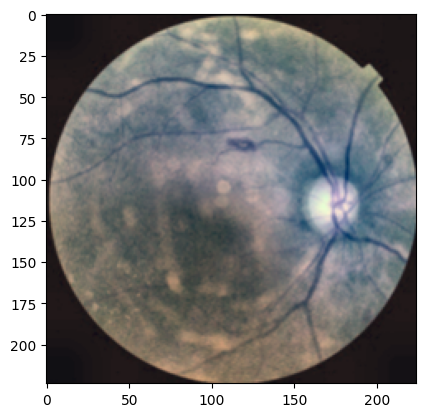

In [29]:
plt.imshow(X_train[0])

## Model

### Model Parameters

In [30]:
num_classes = len(np.unique(y_train))
epochs = 50
batch_size = 32

In [31]:
## converting the data to tf dataset for optimization and deleting the numpy arrays to free up memory
if validation_flag:
    # Converting validation data to tf data
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    # del X_val, y_val

# converting test data to tf dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
del (X_test,)  # y_test

# Converting trainig Data to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
del (X_train,)  # y_train


# if cross testing is enabled, convert the cross data to tf dataset
if cross_testing:
    cross_dataset = tf.data.Dataset.from_tensor_slices((X_cross, y_cross)).batch(
        batch_size
    )
    del X_cross, y_cross

2024-04-21 18:17:28.369245: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 376771584 exceeds 10% of free system memory.
2024-04-21 18:17:28.627518: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 376771584 exceeds 10% of free system memory.
2024-04-21 18:17:28.784487: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1508140032 exceeds 10% of free system memory.
2024-04-21 18:17:29.848435: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1508140032 exceeds 10% of free system memory.


In [32]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    # input_tensor=None,
    input_shape=(224, 224, 3),
    pooling="avg",
)

In [33]:
base_model.trainable = False

In [34]:
# Define the inputs
inputs = tf.keras.Input(shape=(224, 224, 3))

# Ensure the base_model is running in inference mode.
x = base_model(inputs, training=False)

x = layers.Dropout(0.5)(x)  # Dropout layer with 50% dropout rate
# Adding FC (Fully Connected) layers
x = layers.Dense(1000)(x)
x = layers.Dropout(0.5)(x)  # Another Dropout layer with 50% dropout rate
# Adding FC (Fully Connected) layers
x = layers.Dense(500)(x)

# Adding a final layer with SoftMax activation for classification
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Creating the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 efficientnetb0 (Functional)  (None, 1280)             4049571   N          
                                                                            
 dropout (Dropout)           (None, 1280)              0         Y          
                                                                            
 dense (Dense)               (None, 1000)              1281000   Y          
                                                                            
 dropout_1 (Dropout)         (None, 1000)              0         Y          
                                                                            
 dense_1 (Dense)             (None, 500)               500500

In [35]:
# base learning rate
base_learning_rate = 1e-4
# maximum learning rate
max_learning_rate = 1e-2

# Create an instance of SGD optimizer with initial learning rate
optimizer = SGD(learning_rate=base_learning_rate, momentum=0.9, clipnorm=1.0)


# Function to compute class weights using TensorFlow
def compute_class_weights(labels):
    # Convert labels to a 1D tensor if not already
    labels = tf.reshape(labels, [-1])

    # Get unique classes and their indices and counts
    unique_classes, _, class_counts = tf.unique_with_counts(labels)

    # Compute total number of samples
    total_samples = tf.reduce_sum(class_counts)

    # Compute class weights as the inverse of the class frequencies
    class_weights = total_samples / class_counts

    # Create a class weights dictionary mapping class indices to their respective weights
    class_weight_dict = dict(zip(unique_classes.numpy(), class_weights.numpy()))

    return class_weight_dict


class_weight_dict = compute_class_weights(y_train)


# Create triangular learning rate scheduler
def triangular_schedule(epoch):
    """Triangular learning rate scheduler."""
    cycle_length = 10  # Define the length of a cycle
    cycle = math.floor(1 + epoch / (2 * cycle_length))
    x = abs(epoch / cycle_length - 2 * cycle + 1)
    lr = base_learning_rate + (max_learning_rate - base_learning_rate) * max(0, (1 - x))
    return lr


# When fitting the model, include the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(triangular_schedule)

In [36]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [37]:
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

print("Fitting the top layer of the model")
if validation_flag:
    # training the model
    history = model.fit(
        # X_train_tensor,
        # y_train_tensor,
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        # class_weight=class_weight_dict,
        # batch_size=batch_size,
        callbacks=[lr_scheduler],
    )
else:
    history = model.fit(
        # X_train_tensor,
        # y_train_tensor,
        train_dataset,
        epochs=epochs,
        # class_weight=class_weight_dict,
        # batch_size=batch_size,
        callbacks=[lr_scheduler],
    )

Fitting the top layer of the model


2024-04-21 18:17:34.007730: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1508140032 exceeds 10% of free system memory.


Epoch 1/50


2024-04-21 18:17:40.192620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8902
2024-04-21 18:17:40.303059: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


314/314 [==============================] - 13s 23ms/step - loss: 1.4375 - accuracy: 0.4183 - lr: 1.0000e-04
Epoch 2/50
314/314 [==============================] - 7s 22ms/step - loss: 1.1207 - accuracy: 0.5724 - lr: 0.0011
Epoch 3/50
314/314 [==============================] - 7s 22ms/step - loss: 0.9859 - accuracy: 0.6179 - lr: 0.0021
Epoch 4/50
314/314 [==============================] - 7s 22ms/step - loss: 0.9326 - accuracy: 0.6400 - lr: 0.0031
Epoch 5/50
314/314 [==============================] - 7s 23ms/step - loss: 0.8979 - accuracy: 0.6521 - lr: 0.0041
Epoch 6/50
314/314 [==============================] - 7s 22ms/step - loss: 0.8912 - accuracy: 0.6537 - lr: 0.0050
Epoch 7/50
314/314 [==============================] - 7s 22ms/step - loss: 0.8787 - accuracy: 0.6503 - lr: 0.0060
Epoch 8/50
314/314 [==============================] - 7s 22ms/step - loss: 0.8835 - accuracy: 0.6547 - lr: 0.0070
Epoch 9/50
314/314 [==============================] - 7s 22ms/step - loss: 0.8768 - accuracy: 

In [38]:
# Unfreeze the base model
base_model.trainable = True
model.summary(show_trainable=True)

# Re-instantiate the optimizer
optimizer = SGD(learning_rate=base_learning_rate, momentum=0.9, clipnorm=1.0)

model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

print("Fitting the end-to-end model")
# Train end-to-end. Stop before overfit
if validation_flag:
    # training the model
    history = model.fit(
        # X_train_tensor,
        # y_train_tensor,
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        # class_weight=class_weight_dict,
        # batch_size=batch_size,
        callbacks=[lr_scheduler],
    )
else:
    history = model.fit(
        # X_train_tensor,
        # y_train_tensor,
        train_dataset,
        epochs=epochs,
        # class_weight=class_weight_dict,
        # batch_size=batch_size,
        callbacks=[lr_scheduler],
    )

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 efficientnetb0 (Functional)  (None, 1280)             4049571   Y          
                                                                            
 dropout (Dropout)           (None, 1280)              0         Y          
                                                                            
 dense (Dense)               (None, 1000)              1281000   Y          
                                                                            
 dropout_1 (Dropout)         (None, 1000)              0         Y          
                                                                            
 dense_1 (Dense)             (None, 500)               500500

In [39]:
# evaluating the model
test_loss_self, test_acc_self = model.evaluate(test_dataset)

if cross_testing:
    test_loss_cross, test_acc_cross = model.evaluate(cross_dataset)

79/79 [==============================] - 3s 24ms/step - loss: 1.7214 - accuracy: 0.8138


## Results
Make sure to verify the parameters while checking the results

In [40]:
# Printiing the parameters for confirmation
print("Important Parameters:")
print("Base Data Path:", base_data_path)
print("Cross Testing:", cross_testing)
if cross_testing:
    print("Cross Data Path:", cross_data_path)
print("Preprocess IENR:", preprocess_IENR)
print("Preprocess Crop:", preprocess_Crop)
print("Preprocess CN:", preprocess_CN)
print("Augmentation:", apply_augmentation)
print("Validation:", validation_flag)

Important Parameters:
Base Data Path: ../../aws_s3/Ddr/
Cross Testing: False
Preprocess IENR: True
Preprocess Crop: True
Preprocess CN: True
Augmentation: False
Validation: False


In [41]:
if cross_testing:
    print(
        f"Test Accuracies are: Self: {test_acc_self:.2%} | Cross: {test_acc_cross:.2%} | Difference= {test_acc_self - test_acc_cross:.2%}"
    )
else:
    print(f"Test Accuracy self:{test_acc_self:.2%}")

Test Accuracy self:81.38%


### Experimental Metric
We will also evaluate the output as a continuous metric to see if this method of evaluation can capture the change which accuracy metric cannot

In [42]:
# calculating the MSE
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test
mse = np.mean((y_true - y_pred) ** 2)
print(f"MSE: {mse:.2f}")

79/79 [==============================] - 3s 19ms/step
MSE: 0.56
